In [1]:
%load_ext autoreload
%autoreload 2

### Import relevant packages

In [60]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import sklearn
import spotipy
import sys
import time

from itertools import compress
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from spotipy.oauth2 import SpotifyClientCredentials
from typing import List


#----- Local imports
import API_codes # a local file where API keys are stored

from utils.data_extraction import get_playlist_track_features

## Spotipy Client API

Set up a spotipy client API to interact with spotipy and extract relevant data

In [3]:
client_credentials_manager = SpotifyClientCredentials(
    client_id = API_codes.client_ID, 
    client_secret = API_codes.client_secret, 
)
sp_client = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
large_playlist_uri = 'https://open.spotify.com/playlist/5S8SJdl1BDc0ugpkEvFsIL?si=6d4c737ed4104104'
small_playlist_uri = 'https://open.spotify.com/playlist/7mzVswKH5SapmIsE6JovHM?si=d4687728ec534adb'
smallest_playlist_uri = 'https://open.spotify.com/playlist/0dD0PWBiGcUCFyRPOHNART?si=2460a1ca6c544e06'

## Load Data

Here we use a function from the `utils.data_extraction` module to get audio features associated with the songs in a given playlist.

In [71]:
start_time = time.time()
tracks_audio_output = get_playlist_track_features(
    sp_client,
    large_playlist_uri,
    './data/audio_output.csv'
)
end_time = time.time()
print(f'Total elapsed time = {np.round(end_time - start_time, 2)} seconds')

tracks_audio_output.head()

Total elapsed time = 0.07 seconds


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,label
0,0.615,0.779,2,-6.454,1,0.1350,0.0665,0.000000,0.1550,0.453,160.000,audio_features,7zgqtptZvhf8GEmdsM2vp2,spotify:track:7zgqtptZvhf8GEmdsM2vp2,https://api.spotify.com/v1/tracks/7zgqtptZvhf8...,https://api.spotify.com/v1/audio-analysis/7zgq...,208198,4,"Big Machine Records, LLC"
1,0.687,0.845,7,-4.370,1,0.0576,0.1000,0.000000,0.0452,0.809,87.972,audio_features,4Vxu50qVrQcycjRyJQaZLC,spotify:track:4Vxu50qVrQcycjRyJQaZLC,https://api.spotify.com/v1/tracks/4Vxu50qVrQcy...,https://api.spotify.com/v1/audio-analysis/4Vxu...,190227,4,The Valory Music Co.
2,0.818,0.803,1,-4.282,1,0.0797,0.0340,0.000000,0.1530,0.632,106.970,audio_features,6b8Be6ljOzmkOmFslEb23P,spotify:track:6b8Be6ljOzmkOmFslEb23P,https://api.spotify.com/v1/tracks/6b8Be6ljOzmk...,https://api.spotify.com/v1/audio-analysis/6b8B...,225983,4,Atlantic Records
3,0.624,0.876,9,-3.374,1,0.1000,0.0735,0.000000,0.3270,0.781,99.943,audio_features,0afhq8XCExXpqazXczTSve,spotify:track:0afhq8XCExXpqazXczTSve,https://api.spotify.com/v1/tracks/0afhq8XCExXp...,https://api.spotify.com/v1/audio-analysis/0afh...,170827,4,Atlantic Records UK
4,0.614,0.379,4,-10.480,1,0.0476,0.6070,0.000464,0.0986,0.201,107.989,audio_features,1HNkqx9Ahdgi1Ixy2xkKkL,spotify:track:1HNkqx9Ahdgi1Ixy2xkKkL,https://api.spotify.com/v1/tracks/1HNkqx9Ahdgi...,https://api.spotify.com/v1/audio-analysis/1HNk...,258987,4,Atlantic Records UK


## Explore Data

Now let's have a look at the distribution of the data.

In [7]:
tracks_audio_output.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,9961.000000,9961.000000,9961.000000,9961.000000,9961.000000,9961.000000,9961.000000,9961.000000,9961.000000,9961.000000,9961.000000,9.961000e+03,9961.000000
mean,0.567800,0.651601,5.227186,-7.693564,0.654151,0.069461,0.238889,0.099226,0.184909,0.472934,120.467378,2.832725e+05,3.934645
std,0.166121,0.225258,3.585934,4.439375,0.475668,0.074680,0.291055,0.246149,0.153771,0.248978,28.203590,3.687464e+05,0.352907
min,0.000000,0.000000,0.000000,-53.436000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001720e+05,0.000000
25%,0.467000,0.510000,2.000000,-9.158000,0.000000,0.034000,0.015700,0.000000,0.094000,0.274000,99.961000,1.979360e+05,4.000000
50%,0.581000,0.696000,5.000000,-6.512000,1.000000,0.044000,0.096800,0.000034,0.122000,0.468000,119.972000,2.249070e+05,4.000000
75%,0.686000,0.829000,8.000000,-4.884000,1.000000,0.069600,0.383000,0.008950,0.226000,0.670000,138.014000,2.635600e+05,4.000000
max,0.980000,1.000000,11.000000,-0.276000,1.000000,0.957000,0.995000,0.999000,0.988000,0.990000,240.107000,6.000661e+06,5.000000


Something strange about the above summary is that the `loudness` feature has only negative values. A check confirms that the scale is the correct way around and it is likely that the feature is measured in decibels. Nonetheless, it is strange that there are no positive values as dB values can be positive.

Below we plot histograms for some features.

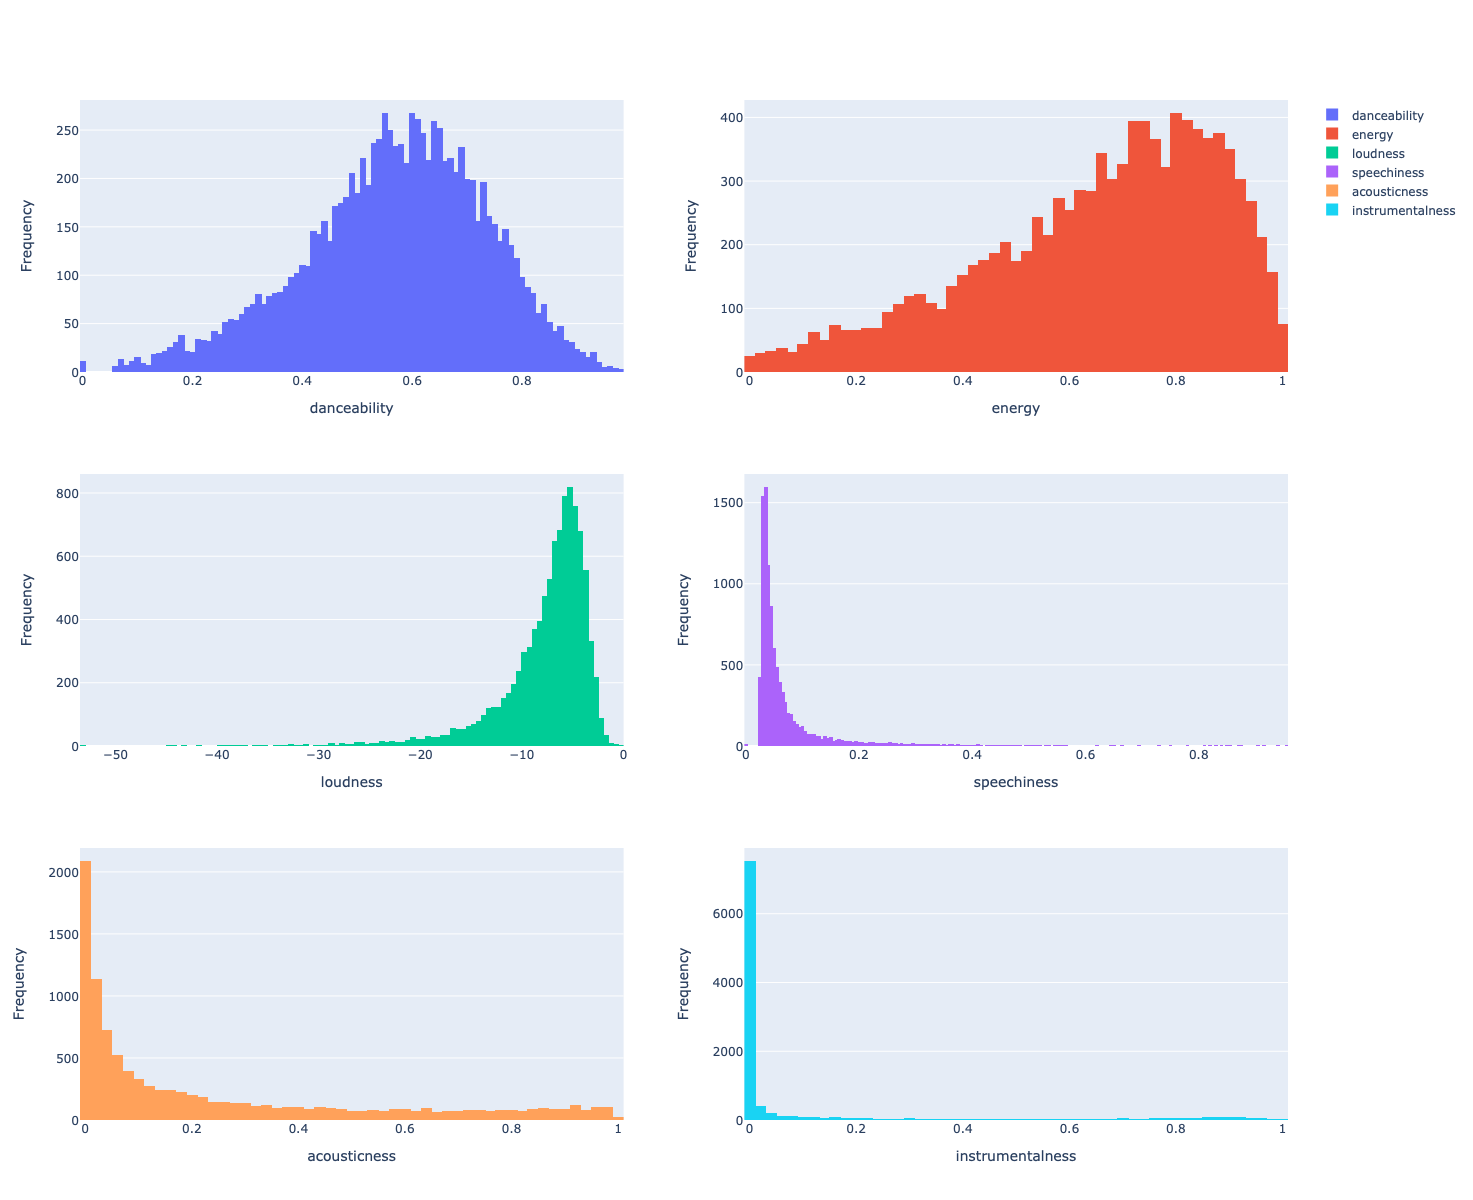

In [67]:
feature_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness']

fig = make_subplots(rows=3, cols=2)

for ii, feature in enumerate(feature_list):
    row = math.floor(ii / 2) + 1
    col = (ii % 2) + 1
    
    fig.add_trace(
        go.Histogram(
            x = tracks_audio_output[feature],
            name=feature,
        ),
        row=row,
        col=col
    )
    
    fig.update_xaxes(title_text=feature, row=row, col=col)
    fig.update_yaxes(title_text="Frequency", row=row, col=col)


fig.update_layout(
    autosize=False,
    width=1200,
    height=1200,
    # title=f"Histogram for feature: {feature}",
    # xaxis_title=feature,
    # yaxis_title="Frequency",
)

fig.show()

## Investigate Different Clustering Algorithms

The following section will not seek to find the best machine learning clustering model, but will instead serve as an opportunity to learn about and investigate different clustering algorithms. Many of these will come from the scikit-learn module `sklearn.cluster`.

### KMeans

The Kmeans algorithm creates a defined number of clusters and optimises the position of the centroids of the clusters such that the total inertia of the clusters is minimised. Inertia is defined as the sum of the squares of the distances between each sample and the centroid of the cluster that it belongs to, where the centroid is some point which exists in the same space as the sample points.

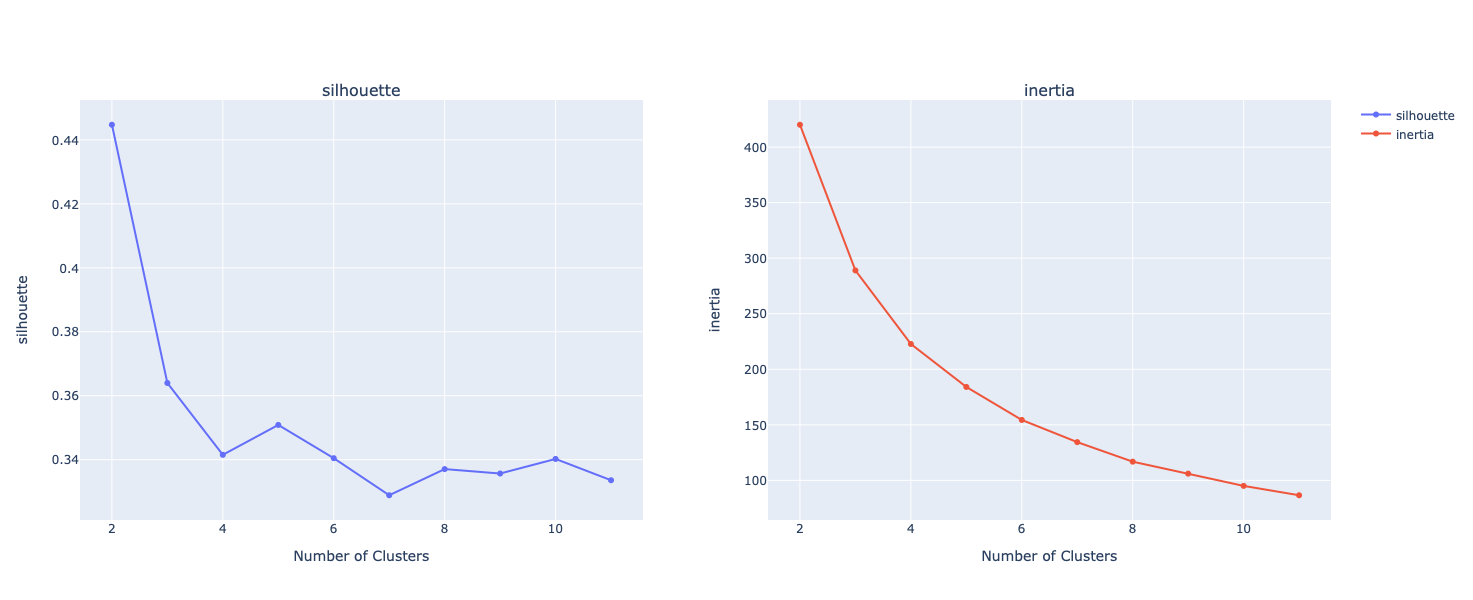

In [87]:
max_clusters = 12
features = ['danceability', 'energy'] #, 'loudness', 'speechiness', 'acousticness', 'instrumentalness']

num_clusters_list = []
silh_score_list = []
inertia_score_list = []
for num_clusters in range(2, max_clusters):
    num_clusters_list += [num_clusters]
    clusterer = KMeans(
        n_clusters = num_clusters, 
        n_init = "auto",
        random_state = 666
    )
    cluster_labels = clusterer.fit_predict(tracks_audio_output[features])

    silh_score_list += [silhouette_score(tracks_audio_output[features], cluster_labels)]
    inertia_score_list += [clusterer.inertia_]
    

fig = make_subplots(rows=1, cols=2, subplot_titles = ['silhouette', 'inertia'])

for ii, (score_name, score_list) in enumerate(zip(['silhouette', 'inertia'], [silh_score_list, inertia_score_list])):
    fig.add_trace(
        go.Scatter(
            x = num_clusters_list,
            y = score_list,
            name = score_name
        ),
        row=1,
        col=ii+1
    )
    
    fig.update_xaxes(title_text = "Number of Clusters", row=1, col=ii+1)
    fig.update_yaxes(title_text = score_name, row=1, col=ii+1)
    
    
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
)

fig.show()